# Predicting House Prices with Regression

This dataset comes from a Kaggle competition and describes 1460 residences in Ames, Iowa based on 79 factors such as size, age and quality of the property. The goal is to develop a model to predict price of the house. Let's also test the notion that house prices have been high lately.

In [1]:
# Load Packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns


# List data paths 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Reading data 
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Initial data analysis and tidying
The first step is to understand our dataset better. I take a look at the data and notice factors like Fireplace Quality and Fence Quality have a lot of missing data. For simplicity, I decided to remove all columns that contain any missing data, reducing the number of factors from 79 to 61. 
I feel this is a poor practice since some factors such as Electrical System are only missing a few values, it'd be better to throw out the few missing values than throw out the entire column. 

In [2]:
# Taking a look 
train.head(5)
# Are there any gaps in the data?
print(train.info())
# Yes Alley, PoolQC, Fence, MiscFeature, and FireplaceQu are missing a lot of data

# Remove all missing values
train = train.dropna(axis='columns',how='any')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<AxesSubplot:>

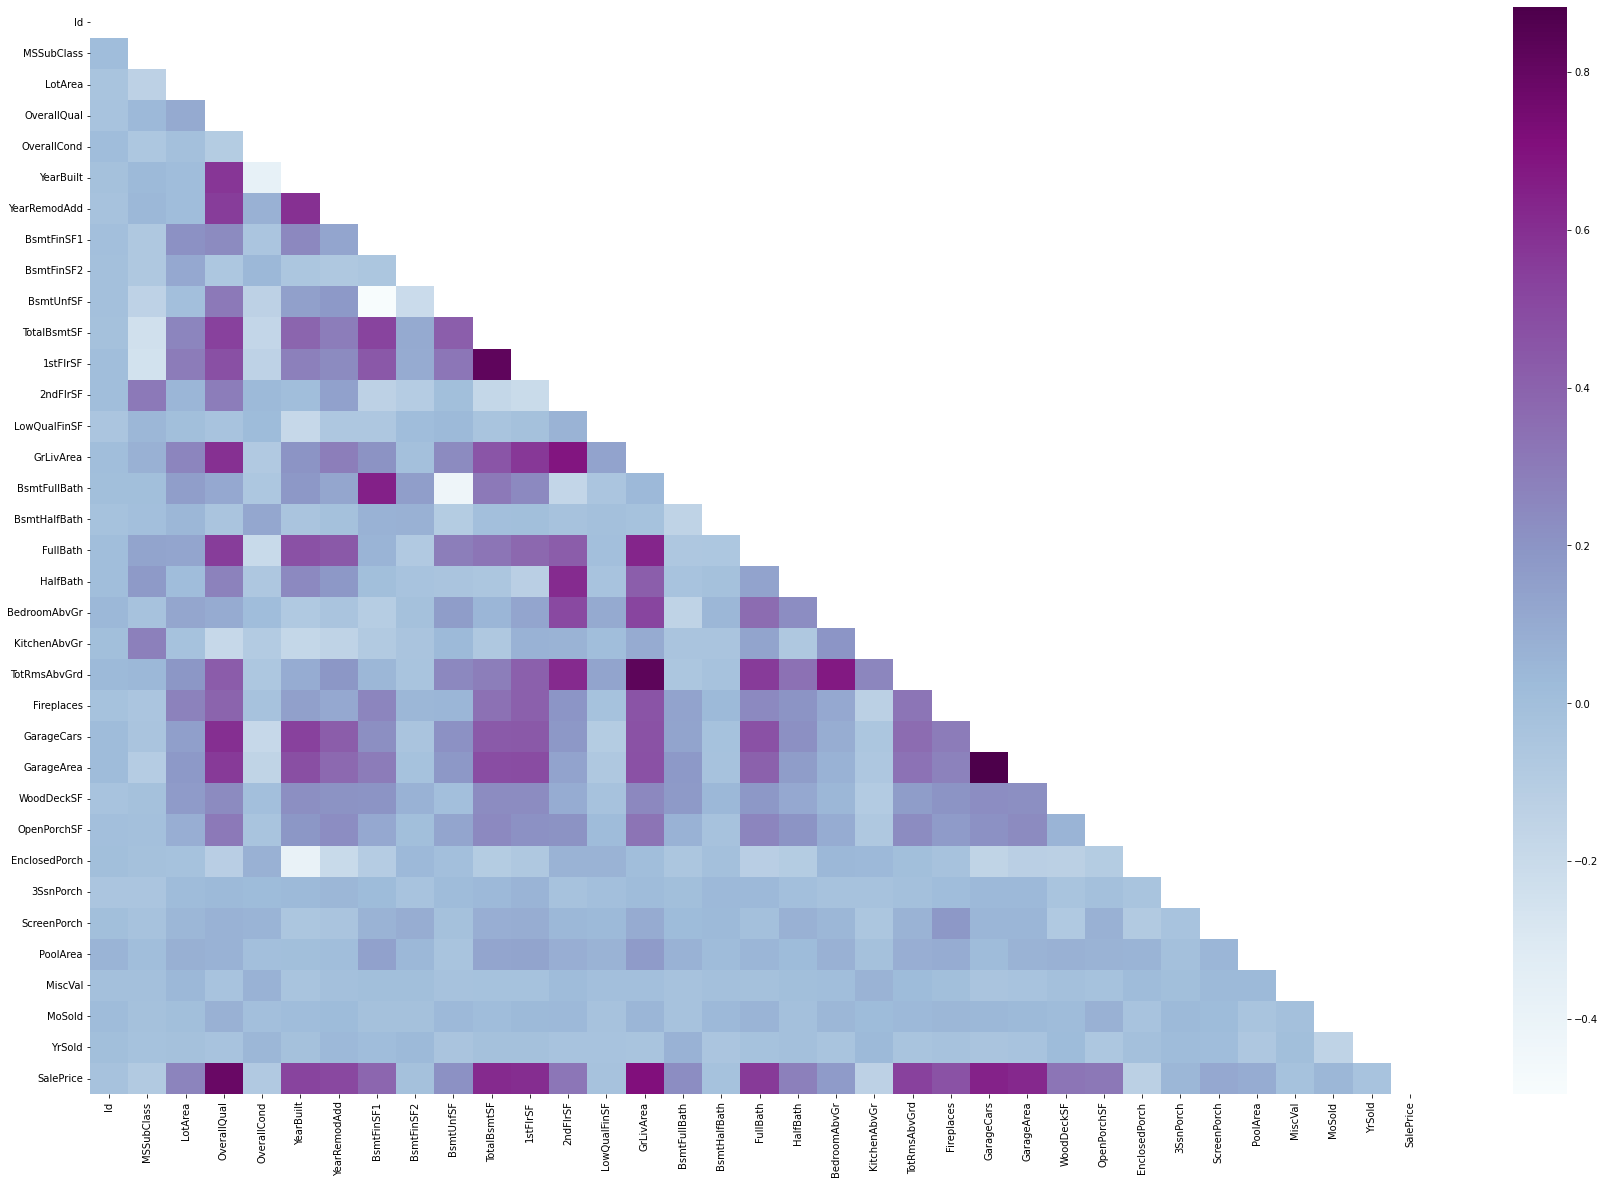

In [3]:
# Correlation heatmap with a triangular mask
plt.figure(figsize=(30,20))
sns.heatmap(train.corr(),mask=np.triu(np.ones_like(train.corr())),cmap="BuPu")

## Model 1: Decision Tree with Correlated Factors
Now that we've visualized and cleaned the data, let's build our first model to predict price. This model will be a decision tree using a few of the most highly correlated factors such as Overall Quality, Year Built and factors relating to Area of the property (how big it is).

In [4]:
y = train.SalePrice # Setting the target variable
features = ['OverallQual','YearBuilt','GrLivArea','GarageCars','GarageArea']
X = train[features]
train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=1) 
model1 = DecisionTreeRegressor(random_state=1)
model1.fit(train_X,train_y)

predictions = model1.predict(test_X)
print(mean_absolute_error(test_y,predictions))

27404.897260273974


On average our model is off by $27,404. Let's see if we can do better just by adding more factors.

## Model 2: Add More Variables and Nodes

In [5]:
y = train.SalePrice # Setting the target variable
features = ['MSSubClass','LotArea','OverallQual','OverallCond','YearBuilt',
           'YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
           '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
           'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
           'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
           'ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']
X = train[features]
train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=1) 
model2 = DecisionTreeRegressor(random_state=1)
model2.fit(train_X,train_y)

predictions = model2.predict(test_X)
print(mean_absolute_error(test_y,predictions))

24960.487671232877


Our model has improved but only slightly by about $2444. This can be refined further by adjusting the max_leaf_nodes input in the DecisionTreeRegressor function. 

In [6]:
# Define a function which computes the MAE for comparison of models with different numbers
# of nodes
def get_mae(max_leaf_nodes,train_X,val_X,train_y,val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes,random_state=1)
    model.fit(train_X,train_y)
    preds_val=model.predict(val_X)
    mae = mean_absolute_error(val_y,preds_val)
    return(mae)

# Compute the MAE for each number in the array, representing number of nodes
node_array = [10,20,30,40,50,60,70,80,90,100]
for max_leaf_nodes in node_array:
    my_mae = get_mae(max_leaf_nodes,train_X,test_X,train_y,test_y)
    print((max_leaf_nodes,my_mae))
    

# Or loop to find the best number in a given array
scores = {leaf_size: get_mae(leaf_size, train_X, test_X, train_y, test_y) 
          for leaf_size in node_array}
best_tree_size = min(scores,key=scores.get)
print(best_tree_size)

(10, 28708.48756812182)
(20, 24526.822765265853)
(30, 24230.812859232345)
(40, 24105.915064808378)
(50, 23754.028827004666)
(60, 23261.34103097117)
(70, 23432.10548805913)
(80, 23352.290564396335)
(90, 23186.79544352743)
(100, 23417.56551999571)
90


In [7]:
model2 = DecisionTreeRegressor(random_state=1,max_leaf_nodes=90)
model2.fit(train_X,train_y)

predictions = model2.predict(test_X)
print(mean_absolute_error(test_y,predictions))

23186.79544352743


Using 90 leaves or nodes in the Decision Tree gives us a MAE of $23,186. Not bad for such a simple model I suppose, but if we want to be more accurate we'll have to be more clever. Let's try a more sophisticated model: a Random Forest.

## Model 3: Random Forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
forest1 = RandomForestRegressor(random_state=1)
forest1.fit(train_X,train_y)
fpreds = forest1.predict(test_X)
print(mean_absolute_error(test_y,fpreds))

16926.217502283107


## Conclusion
The Random Forest model is a nice improvement bringing the MAE down to $16,926, but our model is still not very accurate. It's also not very practical because if you're want to predict what your house will sell for, you'll need to input 61 variables. 
I think the model can be improved further by examining the factors more carefully, getting a better idea which factors we can exclude and seeing if any transformations could help